<h1><center>Predicting protein secondary structures with GORIII</center></h1>

Author: Rawad Ghostin

# Introduction

In previous parts, we've been focused on different methods of aligning protein sequences in order to study some of their features, like homology, similarity, and identity.<br>

During alignments tasks, proteins are represented as a *flat* string of characters. From a more realistic point of view, proteins occupy space in 3 dimensions. Moreover, the spatial structure of a protein actively influences its functions biologically. Analyzing the structure of a protein is particularly significant in bioinformatics, as the shape of a protein affects its activity and its biochemical function. <br>
In this project, we precisely focus on studying the following question:<br>
**What is the structure of a given protein sequence? **<br>

To answer this question, we will first explain protein structures in greater detail. Then, we will introduce available methods to determine such structures and implement a case study: the GOR3 algorithm.
Finally, we will analyze, discuss and emit hypotheses about the results and performance of our structure predictions, which are based on a dataset we build.

# Material and methods

##  Protein structures
The structure of a protein describes how the protein occupies 3-dimensional space. <br>
Such structures actively influence the biological function of proteins and are important for extracting biological information, as to have a better understanding of the protein. In this section, we study different aspects of the protein structures.

### Primary, secondary and tertiary structures
The structure of a protein can be expressed by 3 forms of representations :
- **Primary structure:**  This form is implicit in terms of providing information about the shape. In this form, only the type and order of amino acids is represented as a string.
<figure>
  <img src="img/s1.png">
  <figcaption>Fig.1 - Primary structure</figcaption>
</figure> 
<br>

- **Secondary structure:** In this form, amino acid residues are classified in various shape categories (Helix-$\alpha$, $\beta$-strands, and so forth).
<figure>
  <img src="img/secondary.png">
  <figcaption>Fig.2 - Secondary structure - Yellow: loop, Blue: Strand, Red: Helix</figcaption>
</figure> 
<br>

- **Tertiary structures:** This form is more explicit in terms of providing information about the shape. In addition to the shape categories introduced in the secondary structure, the tertiary structure expresses folds and angles by which the residues are arranged.
  
<figure>
  <img src="img/tertiary.png">
  <figcaption>Fig.3 - Tertiary structure <figcaption>
</figure> 
<br>




### Secondary structure shape classes
In a protein, atoms can be chained by hydrogen bonds in various possible manners.<br>
This has the effect of producing multiple shapes that influence the function of the protein.

Mainly, the shapes we study are:
- Helix-$\alpha$ (H or G, I): molecular structure shaped as a helix
<img src="img/helix.png">

- $\beta$-strand (E or B) : molecular structure shaped as a strand or sheet
<img src="img/beta.png">



- coil (C or T, S): molecular structure randomly shaped

For simplification purposes, we will reduce the representations of the Helix-$\alpha$ to `H`,$\beta$-strand to `E` and coil to `C`.<br>
This function `simplify_stype` is defined below, after importing useful modules to our implementation.

In [1]:
import pickle
import re
from collections import OrderedDict
from math import log10
from statistics import mean, stdev
from matplotlib import pyplot as plt
from difflib import SequenceMatcher

In [2]:
def simplify_stype(stype):
    if stype in {'H', 'G', 'I'}:
        return 'H'
    elif stype in {'E', 'B'}:
        return 'E'
    elif stype in {'T', 'C', 'S', ' '}:
        return 'C'
    else:
        raise Exception("Unrecognized structure type")

## Determining a protein structure
### Experimental methods
There exist experimental methods to deduce the structure of a protein.<br>
Methods like *NMR (nuclear magnetic resonance)*, *X-Ray crystallography* aim to decode the shape of a protein based on experimental data.
It is relevant to note that, although these methods are reliable, they require experimental data that is more often than not absent. Thus, depending principally on these methods can prove to be unpractical.

### Methods based on statistics and neural networks
The ability to sequence genome has given rise to the quantity of available protein information.<br>
Maintained genome databases are constantly updated with new information. Thanks to the explosion of genetic information, it is possible to search the database for a known homologs of an unknown protein structure and obtain some intuition about its structure.<br> 
However, there are many protein sequences for which no known homologs are available. Being able to conjecture some characteristics of the shape of such proteins is convenient in providing indices about the protein's overall activity and structure.<br>
An important observation has been performed by *Christian Anfinsen*, demonstrating that the three-dimensional shape of a protein is determined by the aminoacid sequences.


A method to produce a  tertiary structure from a primary structure does not exist (*yet ?*). Nonetheless, methods based on statistical analysis and neural networks can be employed to derive a secondary structures.<br>
An example of such methods is **GOR**, developed in the late 70s by **G**arnier-**O**sguthorpe-**R**obson.


### GOR
The GOR algorithm is a case study of statistical methods. The algorithm predicts the secondary structure of a protein based on its primary structure.

#### Training based on a dataset
GOR is a statistical method, it uses a dataset containing a large number of proteins for which the structure is known to compute statistical parameters. This phase is known as the *training phase*, as the algorithm uses large amounts of data to produce the best parameters used later in predictions.<br>
The foundation of GOR lies in taking into consideration information about the placement and interactions between amino acids. Three types of information are employed:
- Self-information: Information that the residue carries about its own conformation.
- Directional information: Information about a conformation at a position $j$ carries by a residue at a position $i \neq j$. It is independent of the type of aminoacid at $j$.
- Pair information : Information about a conformation at a position $j$ carries by a residue at a position $i \neq j$. Pair information takes into consideration the type of aminoacid at $j$.

#### Performing the training
Training involves performing statistical analysis on a dataset in order to obtain the values of frequency parameters. These parameters are required for predictions, in later phases.
The statistical parameters are:
- $f_{S_j}$ : Represents the number of times the structure $S_j$ occured accross the whole training set.
- $f_{n-S_j}$ : Represents the number of times the structure $S_j$ did **not** occur accross the whole training set.
- $f_{S_j,R_j}$ : Represents the number of times the structure $S_j$ occured with an aminoacid $R_j$ accross the whole training set.
- $f_{n-S_j,R_j}$ : Represents the number of times the structure $S_j$ did **not** occur with an aminoacid $R_j$ accross the whole training set.
- $f_{S_j, R_{j+m}, R_j}$ : Represents the number of times the structure $S_j$ occured with an aminoacid $R_j$ and having another aminoacid $X$ at a distance of $m$ from $R_j$; where $|m| < WINDOWSIZE$.
- $f_{n-S_j, R_{j+m}, R_j}$ : Represents the number of times the structure $S_j$ did **not** occur having an aminoacid $R_j$ and another aminoacid $X$ at a distance of $m$ frpù $R_j$; where $|m| < WINDOWSIZE$.

##### Sliding Window
GOR computed data include pair information and directional information. These require for a given amino acid to take into consideration its *context* (its position, what are its neighbors, and so forth).<br>
This introduces complications on a computational scale, therefore an approximative method is used, called the *sliding Window*.
For an aminoacid $R$ at a position j, the windown, with `WINDOWSIZE=8`, includes all neighbors of $R$ which are aminoacids at positions p:
$$
p \in [j-m; j+m] \cap [0; len(seq)-1] \text{ where } m=WINDOWSIZE
$$

According to the original GOR paper (Garnier al 1996), this limit of 8 is not arbitrary but is based on studies of information content at increasing separations.

##### Training implementation
The training phase is done with the class `SurveyDic` which implementation is stated below.
The object uses a Python dictionary structure to store the relevant data.
Most notably, building up the information is done in the method `_build_survey`.
The algorithm is based on the following algorithm (in pseudo-code):
```
# upon reading a particular aminoacid R at position j that is typed as S:
f_S ++
f_S_Rj ++
for m in range(-8;8):
  if m!= 0 and 0<=j+m<len(seq):
    f_S_Rj+m_Rj_m ++
```

We note that since the training set is static, computing the dictionary each time might be unoptimized. Thus, we used *serialization* techniques to store the `SurveyDic` object in `survey.pkl` so we can read it instead of computing it on each execution. The serialization is done in the `save_to_file()` method. The unserialization is done by the function `unserialize_SurveyDic` which returns a `SurveyDic` object.

In [3]:
class SurveyDic:
    STYPES = set('HEC')
    AMINOACIDS = 'ACDEFGHIKLMNPQRSTVWY'
    WINDOWSIZE = 8

    def __init__(self, seq_fname, pkl_fname):
        self.seq_fname = seq_fname
        self.pkl_fname = pkl_fname
        self.dic = dict()
        self._build_dic()
        self._build_survey()

    def save_to_file(self):
        with open(self.pkl_fname, 'wb') as f:
            pickle.dump(self, f)

    def _build_dic(self):
        for stype in self.STYPES:
            self.dic[stype] = {'count': 0}
            for aa in self.AMINOACIDS:
                self.dic[stype][aa] = {'count': 0}
                for aa2 in self.AMINOACIDS:
                    self.dic[stype][aa][aa2] = dict()
                    for m in range(1, self.WINDOWSIZE + 1):
                        self.dic[stype][aa][aa2][-m] = 0
                        self.dic[stype][aa][aa2][+m] = 0

    def f_S(self, S):
        return self.dic[S]['count']

    def f_nS(self, S):
        assert S in self.STYPES
        return sum(self.f_S(S=stype) for stype in self.STYPES - set(S))

    def f_S_R(self, S, R):
        return self.dic[S][R]['count']

    def f_nS_R(self, S, R):
        assert S in self.STYPES
        return sum(self.f_S_R(S=stype, R=R) for stype in self.STYPES - set(S))

    def f_S_X_R(self, S, X, R, m):
        return self.dic[S][R][X][m]

    def f_nS_X_R(self, S, X, R, m):
        assert S in self.STYPES
        return sum(self.f_S_X_R(S=stype, X=X, R=R, m=m) for stype in self.STYPES - set(S))

    def inc_S(self, S):
        self.dic[S]['count'] += 1

    def inc_SR(self, S, R):
        self.dic[S][R]['count'] += 1

    def inc_SXR(self, S, X, R, m):
        self.dic[S][R][X][m] += 1

    def _build_survey(self):
        with open(self.seq_fname, 'r') as f:
            line = f.readline()
            while line:
                line = line.strip()
                if line.startswith('>'):
                    a_seq = f.readline().strip()
                    s_seq = f.readline().strip()

                    for j, a, s in zip(range(len(a_seq)), a_seq, s_seq):
                        self.inc_S(s)
                        self.inc_SR(s, a)
                        for m in range(-self.WINDOWSIZE, self.WINDOWSIZE + 1):
                            if m == 0:
                                continue
                            if not (0 <= j + m < len(a_seq)):
                                continue
                            aa2 = a_seq[j + m]
                            self.inc_SXR(S=s, X=aa2, R=a, m=m)
                line = f.readline()


def unserialize_SurveyDic(pkl_fname):
    with open(pkl_fname, 'rb') as f:
        surveydic = pickle.load(f)
    return surveydic

#### Predicting the secondary structure

The GOR algorithm makes use of information theory developed by Shannon and Fano.<br>

The quantity of information measures the amount of information that is brought by a specific "event".
The quantity of information $I(S;R)$ is originally defined as follows:<br>

$$
I(S;R) = log[P(S|R)/P(S)]
$$

where:

- $S$ is one of the three conformations
- $R$ is one of the 20 aminoacids
- $P(S|R)$ the conditional probability for observing a conformation $S$ when a resiue $R$ is present
- $P(S)$ is the probability of observing $S$


Based on probabilities fundamental law, we have:
$$
P(S|R) = P(S,R)/P(R)
$$
where :

- $P(S,R)$ is the probability of observing $S$ **and** $R$
- $P(R)$ the probability of occurence of $R$ in nature.

Since we are working with proteins, there is no way of having an exact theoretical value of the probabilities introduced above. Therefore, using the essential formula of probability $p(A) = \frac{\# occurence A}{\#possibilities}$ (were $A$ is a particular event), we build our own estimations based on the observations in a large database.<br>
Hence, we have the following:
$$
P(S, R) = f_{S,R}/N \\
P(R)= f_R/N \\
P(S) = f_S/N
$$
where:

- $N$ is the total number of aminoacids in the database
- $f_{S,R}$, $f_S$ and $f_R$ are counts explained in a previous section "Performing the training".<br>

Consequently, we can deduce the following formula:
$$
I(S;R) = log( \frac{f_{S,R}/f_R}{f_S/N})
$$


A more general form provides the difference of quantity of information ($\Delta$) taking into account the quantity of information that the event of **not** having $S$ brings. This event is annotated $n-S$ where $n= \{H, E, C\}$, a set of all possible structure. <br>
The more general form is defined as follows, it represents the **self-information**,  information that the residue carries about its own conformation.
$$
I(\Delta S; R) = I(S;R) - I(n-S;R)=log(\frac{f_{S,R}}{f_{n-S,R}}) + log(\frac{f_{n-S}}{f_{S}})
$$

Where:

- $n-S$ : event of **not** having the conformation S (= event of having the other conformations).
- $f_{n-S}$ and $f_{n-S, R}$ are count explained in a previous section "Performing the training".<br>



The equations above can be extented by taking into consideration the **context** of the occurence of the event.<br>
The context is defined by the aminoacids surrounding the amino acid $R$ at a position $j$.<br>
The following forumla determines the quantity of information brought by having $S$ at a position $j$ in the sequence composed by $R_1,...,R_n$:
$$
I(\Delta S_j, R_1,R_2,...,R_n) = log[P(S_j, R_1,...,R_n)/P(n-S_j,R_1,..., R_n)] + log[P(n-S)/P(S)]
$$

Where:

- $S_j$ : event of having the conformation S at position $j$.
- $R_x$: the aminoacid $R$ at position $x$.
- $P(S_j, R_1,...,R_n)$ is the probability of occurence of S at a position $j$ in the sequence composed by $R_1,...,R_n$.
- $P(n-S_j, R_1,...,R_n)$ is the probability of S **not** occuring at a position $j$ in the sequence composed by $R_1,...,R_n$.
- $P(n-S)$ the probability of **not** having S in nature.

A problem we face with such formula is determining the value of $P(S_j, R_1,...,R_n)$ which is impossible to calculate. Thus, we are required to employ approximations. We limit the context to a *window* with size 8. (*cfr.* Sliding window in the "performing the training" section.<br>
The above formula using approximations becomes:
$$
I(\Delta S_j, R_1,R_2,...,R_n) \approx I(\Delta S_j\; R_j) + \sum_{m=-8\\m\neq0}^{m=8} I(\Delta S_j\; R_{j+m})
$$

Where:

- $R_{j+m}$ is an aminoacid $R$ at a position $j+m$.

The first part of the formula ($I(\Delta S_j\; R_j)$ represents **self-information** whereas the other part ($\sum_{m=-8\\m\neq0}^{m=8} I(\Delta S_j\; R_{j+m}$) represents the **directional information**, which is information about a conformation at a position j carries by a residue at a position i≠j. It is independent of the type of aminoacid at j.

Computed for the 3 types of structures (H,E and C), the highest value of the above equation determines the conformation of the aminoacid $R$ at position $j$.
Hence; the conformation of an amino acid $R$ at $j$ is:
$$
conformation = argmax(I(\Delta H_j, R_1,R_2,...,R_n), I(\Delta E_j, R_1,R_2,...,R_n), I(\Delta C_j, R_1,R_2,...,R_n))
$$


An additional approximation is introduced in GOR version 3 called the **pair information**, which is the information about a conformation at a position j carried by a residue at a position i≠j. Pair information takes into consideration the type of aminoacid at j. We now consider the correlation between the type of residues in the window and the type of the residue to be predicted. <br>
Thus ,the new version of the formula is :
$$
I(\Delta S_j, R_1,R_2,...,R_n) \approx I(\Delta S_j\; R_j) + \sum_{m=-8\\m\neq0}^{m=8} I(\Delta S_j; R_{j+m}|R_j)
$$
Where:

$I(\Delta S_j\; R_{j+m}|R_j)$ is the quantity of information brought when having the conformation $S$ at a position $j$ and an aminoacid at a position $j+m$ in the window , *knowing that* the aminoacid $R$ occurs at position $j$.<br>
This quantity is calculated with the following formula:
$$
I(\Delta S_j\; R_{j+m}|R_j) = log(\frac{f_{S_j,R_{j+m},R_j}}{f_{n-S_j, R_{j+m},R_j}}) + log(\frac{f_{n-S_j,R_j}}{f_{S_j,R_j}})
$$


In [4]:
class GOR3:
    """
    Basic GOR3: given a sequence and a SurveyDic predicts a secondary structure
    """
    STYPES = 'HEC'

    def __init__(self, a_seq, surveydic, protid=None):
        self.protid = protid
        self.a_seq = a_seq
        self.sv = surveydic
        self.predicted = ''
        self._pretty_predicted = ''
        self.integral_inf = []
        self.build_structure()

    def get_window_at(self, j):
        """
        returns the window of aminoacid at position j in format {distance: aminoacid}
        """
        window = dict()
        for m in range(-8, 9):
            if m != 0 and 0 <= j + m < len(self.a_seq):
                window[m] = self.a_seq[j + m]
        return window

    def _I_delta(self, S, R):
        """
        returns the qty of information having structure S associated to aminoacid R
        """
        return log10(self.sv.f_S_R(S, R) / self.sv.f_nS_R(S, R)) + log10(self.sv.f_nS(S) / self.sv.f_S(S))

    def _I_delta_ax(self, S, X, R, m):
        """
        returns the qty of information having structure S associated to aminoacid R ;
        having aminoacid X at distance m
        """
        return log10(self.sv.f_S_X_R(S, X, R, m) / self.sv.f_nS_X_R(S, X, R, m)) + log10(
            self.sv.f_nS_R(S, R) / self.sv.f_S_R(S, R))

    def local_I(self, S, j):
        """
        return qty of information having structure S at a position j.
        This formula follows GOR3
        """
        R = self.a_seq[j]
        I = self._I_delta(S, R)
        window = self.get_window_at(j)
        for m in window.keys():
            I += self._I_delta_ax(S=S, R=R, X=self.a_seq[j + m], m=m)
        return I

    def build_structure(self):
        """
        Predicts the structure of the given aminoacid sequence a_seq
        """
        self.predicted = ''
        for j in range(len(self.a_seq)):
            tmp = []
            max_ = float('-inf'), None      # value, type  ; -inf initially to force reevaluation
            for stype in self.STYPES:
                I = self.local_I(S=stype, j=j)
                if I > max_[0]:
                    max_ = I, stype
                tmp.append(I)
            self.predicted += max_[1]
            self.integral_inf.append(tuple(tmp))

    def show_plot(self):
        x = [i for i in range(len(self.a_seq))]
        plt.plot(x, [y[0] for y in self.integral_inf], color='red', label="a-Helix")  # I_H
        plt.plot(x, [y[1] for y in self.integral_inf], color='blue', label="b-Strand")  # I_E
        plt.plot(x, [y[2] for y in self.integral_inf], color='green', label="Coil")  # I_C
        plt.legend()
        plt.ylabel('Information Qty')
        plt.xlabel('Position')
        plt.show()


    def __str__(self):
        s = '[*] Solution\n'
        if self.protid:
            s += 'Protein ID: %s\n' % self.protid
        s += 'aminoacid sequence: %s\n' % self.a_seq
        s += 'predicted sequence: %s\n' % (self.predicted if self.predicted else 'N/A')
        s += "length: %s\n" % len(self.a_seq)
        return s

## Building a dataset

The GOR algorithm uses information based on the probability of finding an amino acid in a helix-$\alpha$, a $\beta$-strand or a coil in order to predict the secondary structure of the protein. To compute these probabilities, we need to use statistical data contained in the folder `dssp`.
In this project, we are provided with the `dssp` folder that contains data of secondary structures of a $3713$ proteins (fetched from *WHATIF*). We will explain how to build a dataset using these data.

Our dataset is split into  parts, a *training set* and a *test set* which contain respectively the first $3000$ proteins and the remaining $713$ proteins.<br>
The training set is used to calculate various parameters based on statistical analysis that will be useful for predictions. The test set is used to evaluate the performance and quality of our predictions.<br>

Each protein is composed of multiple chains.  Parsing and using all chains of all proteins would be computationally difficult to achieve in the scope of this project. Therefore, we are provided with `CATH_info.txt`, a file indicating which chains to be parsed for each protein.


#### Parsing a DSSP entry
The DSSP files hold information about the proteins as well as their structure.
Here is an example segment a DSSP file taken from 1A2P.dssp:
```
 #  RESIDUE AA STRUCTURE BP1 BP2  ACC     N-H-->O    O-->H-N    N-H-->O    O-->H-N    TCO  KAPPA ALPHA  PHI   PSI    X-CA   Y-CA   Z-CA 
    1    3 A V              0   0  132      0, 0.0     2,-0.7     0, 0.0    46,-0.0   0.000 360.0 360.0 360.0 129.8   18.0   38.6   42.8
    2    4 A I        +     0   0   64      1,-0.1    19,-0.2     5,-0.1     0, 0.0  -0.906 360.0 135.3-107.1 108.1   19.6   41.8   44.1
    3    5 A N        +     0   0   26     -2,-0.7    72,-3.1    71,-0.1    73,-0.2   0.241  33.0 106.3-141.9  23.5   20.3   44.0   41.1
    4    6 A T  S  > S-     0   0   66     70,-0.2     4,-2.5    71,-0.1     5,-0.4  -0.574  76.2-111.7-100.6 163.9   19.2   47.6   41.9
    5    7 A F  H  > S+     0   0   29     -2,-0.2     4,-2.1     1,-0.2     5,-0.2   0.947 118.9  39.3 -56.0 -49.1   21.3   50.6   42.7
    6    8 A D  H  > S+     0   0  100      2,-0.2     4,-2.3     1,-0.2     5,-0.2   0.923 116.2  51.1 -71.8 -38.0   20.1   50.7   46.3
```
As we can observe, the third, fourth and fifth columns provide meaningful data about the chain identifier, the aminoacid and the type of (secondary) structure of that aminoacid. We note that no information in the fifth column, the structure type column, represents a coil as well. <br>
The function `parse_dssp_line` takes in parameter a line (entry) of a file and returns its relevant data in a tuple format: `(chain_id, aminoacid, structure_type)`.

In [5]:
def parse_dssp_line(line):
    """ Given line in dssp return chainid, aminoacid, stype """
    re_data = re.findall(r"^\d+\s+-?\d+[A-Z\s](.)\s(.)\s\s(.)\s+.+\d+", line)
    assert (len(re_data) == 1 and len(re_data[0]) == 3 and re_data[0][0].isalnum() and re_data[0][
        1].isalpha() and re_data[0][2] in {'H', 'G', 'I', 'E', 'B', 'T', 'C', 'S', ' '})
    return re_data[0]

#### Parsing CATH_info
Parsing all chains of all proteins would be computationally difficult in the scope of this project.
`CATH_info.txt` indicates which chains to be parsed for each protein.
The format of an entry in CATH_info is:
`protein_id+chain_id` <br>

We note that there are more than $3713$ entries in the `CATH_info.txt` file because in some cases we are asked to parse multiple chains from the same protein. <br>
The function `parse_cathinfo` takes in parameter the cath_info file path and returns a dictionary that contains which chains to parse for each protein, in the format: `{protein_id: [chains to parse]}`:


In [6]:
def parse_cathinfo(cath_info_fname):
    """ Return dictionary proteinid:[chains to parse] from CATH_info"""
    data = OrderedDict()
    with open(cath_info_fname, 'r') as f:
        line = f.readline()
        while line:
            line.strip()
            line = line.split()[0]
            filename = line[:4]
            chain_id = line[-1]
            if filename in data:
                data[filename].append(chain_id)
            else:
                data[filename] = [chain_id]
            line = f.readline()
    return data

#### Parsing the DSSP folder :<br>

The `dssp` folder contains data of secondary structures of a large variety of proteins (3713 proteins exactly).<br>
To build a dataset, we need to parse each protein of the dssp folder according to the `CATH_info.txt` file.<br>
This is achieved by the function `parse_dssp` which returns the parsed data in as a list of protein objects.
The function first uses `parse_cath_info` to extract information about which chain to parse, then proceeds to read the files and store the data in the dictionary.<br>

We note that the amino acids in lowercase represent Cysteines.
Aminoacids X, Z, and B are ignored because the probability of their occurrence is 0, according to the data of Swissprot (discussed in the previous project).

<br>
The function is defined as follows, it uses a `Protein` structure to store data for practical purposes:

In [7]:
class Protein:
    def __init__(self, protid):
        self.protid = protid
        self.name = ''
        self.organism = ''
        self.chains = dict()
        
        
def parse_dssp(dssp_path, cath_info_fname):
    """ given path to dssp and cath_info, return list of protein objects """
    cathinfo_dic = parse_cathinfo(cath_info_fname)

    out = []

    # parsing
    for protid in cathinfo_dic.keys():
        protein = Protein(protid=protid)
        dssp_file = '%s/%s.dssp' % (dssp_path, protid)
        with open(dssp_file, 'r') as f:
            # seek start of relevant data
            line = f.readline()
            while not line.strip().startswith('#'):
                # name of prot
                if line.startswith('COMPND'):
                    re_data = re.findall(r'MOLECULE:\s(.+);', line)
                    protein.name = re_data[0] if re_data else ''
                # organism
                elif line.startswith('SOURCE'):
                    re_data = re.findall(r'ORGANISM_SCIENTIFIC:\s(.+);', line)
                    protein.organism = re_data[0] if re_data else ''
                line = f.readline()

            # start reading relevant data
            line = f.readline()
            while line:
                line = line.strip()
                try:
                    chaind_id, aminoacid, stype = parse_dssp_line(line)
                    # lower char amino acids are C
                    if aminoacid.islower():
                        aminoacid = 'C'
                    # register if correct chain and not XZB
                    if chaind_id in cathinfo_dic[protid] and aminoacid not in {'X', 'Z', 'B'}:
                        if chaind_id in cathinfo_dic[protid]:
                            if chaind_id in protein.chains.keys():
                                protein.chains[chaind_id]['a_seq'] += aminoacid
                                protein.chains[chaind_id]['s_seq'] += simplify_stype(stype)
                            else:
                                protein.chains[chaind_id] = {'a_seq': aminoacid, 's_seq': simplify_stype(stype)}
                        else:
                            raise Exception("logic error")

                except AssertionError as e:
                    assert ('!' in line)
                finally:
                    line = f.readline()
        out.append(protein)
    return out

#### Building the training and test dataset :<br>
The training set contains the first $3000$ proteins. The set will be used to compute statistical parameters.<br>
The test set contains the remaining $713$ proteins. The set will be used to test the quality of our algorithm.<br>
Building a dataset is done with the function `make_train_test_set`. It uses `parse_dssp` to gather the data of all proteins in a dictionary, then split and write them to the training and test files, `train.txt` and `test.txt` respectively.<br>
The format of an entry in the datasets is:
```
> protein_id|protein_name|organism
aminoacid_sequence
structure_seq
```
The function is defined as follows:

In [8]:
def write_dataset_entry(fp, protein, chain_id):
    """
    Given aminoacid and structure sequence write to dataset file
    fp: file pointer
    protein: protein object
    chain_id: chain to write
    """
    a_seq = protein.chains[chain_id]['a_seq']
    s_seq = protein.chains[chain_id]['s_seq']
    header = ">%s|%s|%s" % (protein.protid, protein.name, protein.organism)
    body = "%s\n%s" % (a_seq, s_seq)
    to_write = header + '\n' + body + '\n'
    fp.write(to_write)


def make_train_test_set(out_train_fname, out_test_fname, dssp_path, cath_info_fname, nprot_train=3000):
    """
    out_train_fname: filename of training dataset
    out_test_fname: filename of test_dataset
    dssp_path: path of the dssp folder where dssp files are present
    cath_info_fname: filename of the cath_info file
    nprot_train: number of proteins for the training set
    """
    proteins = parse_dssp(dssp_path=dssp_path, cath_info_fname=cath_info_fname)
    total_c = 0  # total entries count
    prot_c = 0  # proteins count

    # writing the training set
    with open(out_train_fname, 'w') as f:
        for protein in proteins[:nprot_train]:
            prot_c += 1
            for chain_id in protein.chains.keys():
                write_dataset_entry(f, protein, chain_id)
                #print('written %s %s - %s to train' % (prot_c, total_c, protein.protid))
                total_c += 1

    # writing the test set
    with open(out_test_fname, 'w') as f:
        for protein in proteins[nprot_train:]:
            prot_c += 1
            for chain_id in protein.chains.keys():
                write_dataset_entry(f, protein, chain_id)
                # print('written %s %s - %s to test' % (prot_c, total_c, protein.protid))
                total_c += 1
    print('Finished writing datasets')

## Testing the quality of a structure prediction
Testing the performance and quality of our predictor is crucial because it establishes the degree of trust we can give the predictor. We test the quality of our implementation by performing predictions on <u>completely new</u> proteins for which the true structure sequence is known. Such proteins are stored in the test dataset `TEST_FILE`. For each of these predictions, we have consequentially the $Q_3$, $MCC_H$, $MCC_C$ and $MCC_E$ parameters representing the accuracy of this *individual* prediction (quality of one prediction).<br>

#### Q3

The prediction accuracy $Q3$ represents the percentage of accurracy of the secondary structure predicted against the original structure.<br>
$Q_3$ is calculcated as follows:
$$
Q_3 (\%) = \frac{ N_{ correctly\_predicted\_residues}}{N_{residues}}
$$

We note that the pure random $Q_3$ is $1/3 (1/3\alpha, 1/3\beta, 1/3 coil) \approx 0.38 $.<br>
It is possible to have badly predicted sequences that give a greater $Q_3$ than the pure random accuracy.<br>
Therefore, this parameter alone is not relevant and should always be accompanied by other statistical parameters, such as $MCC$.

Example Q3 evaluation on a sequence of 26 residues:<br>
<img src="img/q3.png" >

#### MCCx
The MCC (Matthew Correlation Coefficient) analysis is used in machine learning to measure the quality of predictions. It takes in consideration true/false positives and negatives to scope the accuracy of predictions.

MCC is type-specific. It means that, in our case, it studies the accuracy of the prediction from the point of view of a specific shape category, $c$ in this instance.
The prediction of a structure all come down to 4 possible cases:

Possible cases for $MCC_c$, where $c$ is the shape we're analysing and $d$ any other shape having $c \neq d$:
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-cly1{text-align:left;vertical-align:middle}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-cly1">case</th>
    <th class="tg-cly1">Predicted</th>
    <th class="tg-cly1">Original</th>
  </tr>
  <tr>
    <td class="tg-cly1">TP</td>
    <td class="tg-cly1">c<br></td>
    <td class="tg-cly1">c</td>
  </tr>
  <tr>
    <td class="tg-cly1">TN<br></td>
    <td class="tg-cly1">d</td>
    <td class="tg-cly1">d</td>
  </tr>
  <tr>
    <td class="tg-0lax">FP</td>
    <td class="tg-0lax">c</td>
    <td class="tg-0lax">d</td>
  </tr>
  <tr>
    <td class="tg-0lax">FN</td>
    <td class="tg-0lax">d</td>
    <td class="tg-0lax">c</td>
  </tr>
</table>

$MCC$ is calculated as follows:
$$
MCC = \frac{TP \cdot TN - FP \cdot FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}} \text{ and } mcc \in [-1;1]
$$

The value of the MCC represents the effectiveness of the predictor.

<img src="img/mcc_chartx.png">


Example of MCC:
<img src="img/mcc.png">

We note that considering the form of $(TP+FP)(TP+FN)(TN+FP)(TN+FN)$, having any factor equals to $0$ yields a zero division case while computing the $MCC$. We remediate to this situation by arbitrarily setting $(TP+FP)(TP+FN)(TN+FP)(TN+FN)=1$.
More precisely, if one of the factors at the denominator is 0 since it is an addition of 2 positive integers, we have that both of the operands are null. In this case, the numerator $TP \cdot TN - FP \cdot FN$ is 0 as well and $mcc=0$, counting as a pure random guess

In this project, we will make use of both $Q_3$ and $MCC_x$ to evaluate the quality of our predictions.
More precisely, we will compute the mean and standard deviation values of $Q_3$ and $MCC_x$ after having predicted a wide set of new protein sequences. This task is performed in a farther section.


The predictions and evaluations can be done with the subclass `GOR3Evaluator` defined as follows:

In [9]:
class GOR3Evaluator(GOR3):
    """
    Evaluator for the GOR3 algorithm, in contrast with GOR3 class,
    GOR3Evaluator takes into consideration the true structure sequence "s_seq"
    """
    def __init__(self, a_seq, s_seq, surveydic, protid=None):
        super().__init__(a_seq=a_seq, surveydic=surveydic, protid=protid)
        self.s_seq = s_seq

    def q3(self):
        """
        Returns the Q3 of the evaluation
        """
        if not self.predicted:
            return 0
        count_correct = 0
        for s1, s2 in zip(self.s_seq, self.predicted):
            if s1 == s2:
                count_correct += 1
        return round(count_correct / len(self.s_seq) * 100, 3)

    def mcc(self, S):
        """
        Returns the MCC_S of the evaluation where S is a structure type
        """
        if not self.predicted:
            return 0
        tp, tn, fp, fn = 0, 0, 0, 0
        for s1, s2 in zip(self.s_seq, self.predicted):
            if s1 == s2:
                if s1 == S:
                    tp += 1
                else:
                    tn += 1
            else:
                if s1 == S:
                    fn += 1
                elif s2 == S:
                    fp += 1
        try:  # todo : check zero div case
            res = ((tp * tn) - (fp * fn)) / (((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5)
        except ZeroDivisionError:
            res = ((tp * tn) - (fp * fn)) / 1
        return round(res, 3)

    def _make_pretty_predicted_str(self):
        """
        Make the predicited sequence pretty with colors
        RED: prediction error
        GREEN: correct prediction
        """
        GREEN = "\u001b[32m"
        RED = "\u001b[31m"
        RST = '\u001b[0m'

        curr_green = None
        for s1, s2 in zip(self.predicted, self.s_seq):
            if s1 == s2:
                if curr_green is False or curr_green is None:
                    self._pretty_predicted += GREEN
                    curr_green = True
            else:
                if curr_green is True or curr_green is None:
                    self._pretty_predicted += RED
                    curr_green = False
            self._pretty_predicted += s1
        self._pretty_predicted += RST

    @property
    def pretty_predicted(self):
        """
        Returns the pretty string version of the prediction
        """
        if self._pretty_predicted == '':
            assert self.predicted != ''
            self._make_pretty_predicted_str()
        return self._pretty_predicted

    def __str__(self):
        s = '[*] Solution\n'
        if self.protid:
            s += 'Protein ID: %s\n' % self.protid
        s += 'aminoacid sequence: %s\n' % self.a_seq
        s += 'structure sequence: %s\n' % self.s_seq
        s += 'predicted sequence: %s\n' % (self.pretty_predicted if self.predicted else 'N/A')
        s += "length: %s\n" % len(self.a_seq)
        s += 'Q3: %s %%\n' % self.q3()
        for stype in self.STYPES:
            s += 'MCC_%s: %s \n' % (stype, self.mcc(stype))
        return s



# Results and discussion

We define essential constants and file paths required to the use of the programs in later sections.

In [10]:
TRAIN_FILE = 'rsrc/dataset/train.txt'
TEST_FILE = 'rsrc/dataset/test.txt'
PKL_TRAIN_DATA_FILE = 'rsrc/dataset/survey.pkl'
DSSP_PATH = 'rsrc/dataset/dssp'
DSSP_TEST_PATH = 'rsrc/dataset/dssp_test'
CATHINFO_FILE = 'rsrc/dataset/CATH_info.txt'
CATHINFO_TEST_FILE = 'rsrc/dataset/CATH_info_test.txt'
STYPES = 'HEC'

### Building the training and test datasets

We start by building the training and test datasets. These are required for training and evaluating the performance of the GOR algorithm. The function `make_train_test_set` generates the 2 files in the `dssp` folder, as defined previously by constants.

In [11]:
make_train_test_set(
    out_train_fname=TRAIN_FILE,
    out_test_fname=TEST_FILE,
    dssp_path=DSSP_PATH,
    cath_info_fname=CATHINFO_FILE
)

Finished writing datasets


### Training phase
In this phase, we train our algorithm by computing the statistical parameters of the training dataset, namely:
- $f_{S_j}$ & $f_{n-S_j}$
- $f_{S_j,R_j}$ & $f_{n-S_j,R_j}$
- $f_{S_j, R_{j+m}, R_j}$ & $f_{n-S_j, R_{j+m}, R_j}$
<br>
We use the training set `TRAIN_FILE` which contains 3000 proteins.
The results are serialized in a pickle file for eventual reusability.

In [12]:
surveydic = SurveyDic(TRAIN_FILE, pkl_fname=PKL_TRAIN_DATA_FILE)
surveydic.save_to_file()

surveydic_test = SurveyDic(TEST_FILE, 'rsrc/dataset/testsurvey.pkl')  # used later in discussions
surveydic_test.save_to_file()

### Evaluation phase
For each of these predictions, we have consequentially the $Q_3$, $MCC_H$, $MCC_C$ and $MCC_E$ parameters representing the accuracy of this *individual* prediction.<br>
The individual degree of precision of an individual prediction is insignificant alone because it doesn't consider other prediction cases.<br> Therefore, the **global** quality for the predictor is determined by computing the mean value and standard deviation of each of these parameters for a wide set of new proteins.

The testing of our implementation is done as follows:

In [13]:
q3_list = []
mcc = {stype: [] for stype in STYPES}

with open(TEST_FILE, 'r') as f:
    line = f.readline()
    while line:
        line = line.strip()
        a_seq = f.readline().strip()
        s_seq = f.readline().strip()
        gor = GOR3Evaluator(a_seq=a_seq, s_seq=s_seq, surveydic=surveydic)

        # log individual quality data
        q3_list.append(gor.q3())
        for stype in mcc.keys():
            mcc[stype].append(gor.mcc(stype))
        line = f.readline()

# output results
print('[*] Statistical analysis results')
print('Q3: mean:%.3f  -  sd:%.3f' % (mean(q3_list), stdev(q3_list)))
for stype in mcc.keys():
    print('MCC %s: mean:%.3f  -  sd:%.3f' % (stype, mean(mcc[stype]), stdev(mcc[stype])))   

[*] Statistical analysis results
Q3: mean:61.297  -  sd:7.327
MCC H: mean:0.342  -  sd:0.161
MCC E: mean:0.327  -  sd:0.159
MCC C: mean:0.357  -  sd:0.120


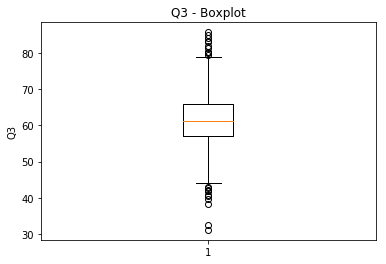

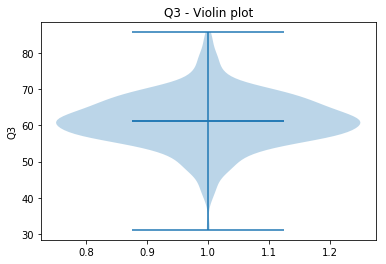

[Text(0, 0, 'H'), Text(0, 0, 'E'), Text(0, 0, 'C')]

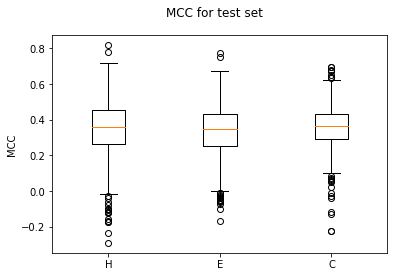

In [14]:

# Q3 boxplot
plt.boxplot(q3_list)
plt.title('Q3 - Boxplot')
plt.ylabel('Q3')
plt.show()

# Q3 violin plot
plt.violinplot(q3_list, showmeans=True, showmedians=True)
plt.title('Q3 - Violin plot')
plt.ylabel('Q3')
plt.show()


# MCC boxplot
fig, ax = plt.subplots()
ax.boxplot(mcc.values())
fig.suptitle('MCC for test set')
plt.ylabel('MCC')
ax.set_xticklabels(mcc.keys())

### Observations and discussions on the quality of predictions

#### Observations on Q3
The mean value of Q3 is $\mu =61.297\%$ with a standard deviation of $\sigma = 7.327 \%$ .<br>
The standard deviation $\sigma$ represents the degree of compactness of the observed data.  A standard deviation of $\sigma=7.327\%$ means that the mean value of $Q3$ could be fluctuating on a distance of $\pm 7.327 \%$.


As observed on the boxplot, the interquartile range $IQR$ is $\approx IQR \in [58, 68] %$. This means that $50 \%$ of Q3 values are contained within this range.<br>. Furthermore, the statistical maximum is observed to be $\approx 80\%$. The statistical minimum is observed to be $\approx 45\%$, which is **greater** than a pure random $Q3$ value of $38\%$ by $\approx 1.5$ standard deviations ($\sigma = 7.327$). This indicates that statistically in worst cases, the GOR3 algorithm still performs better than a random solution. More precisely, even in worst cases, the GOR3 algorithm provides a higher entropy than a random guess.<br>
We note that a random Q3 is calculated by $Q_3 \approx (1/3\alpha, 1/3\beta, 1/3 coil) \approx 0.38 $.<br>

Although outliners exist (values not contained within the statistical minimum-maximum range), we can observe on the violin plot of Q3 that the density of the probability of these occurrences is marginally low. <br>

In addition, we notice that the data is spread more or less symmetrically. This could be an indicator that our dataset is unbiased and correctly formed.<br>

The theorical value of the mean and standard deviation $Q_3$ for the GOR3 algorithm as presented in the original paper *"GOR Method for Predicting Protein Secondary Structure from Amino Acid Sequence"* slightly differ from our presented results:
    
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-noaz{background-color:#ffffff;color:#333333;border-color:inherit;text-align:left;vertical-align:middle}
</style>
<table class="tg">
  <tr>
    <th class="tg-noaz"></th>
    <th class="tg-noaz">Present</th>
    <th class="tg-noaz">Expected<br></th>
  </tr>
  <tr>
    <td class="tg-noaz">Q3 mean (%)<br></td>
    <td class="tg-noaz">61.297<br></td>
    <td class="tg-noaz">63.3<br></td>
  </tr>
  <tr>
    <td class="tg-noaz">Q3 stdev (%)</td>
    <td class="tg-noaz">7.327</td>
    <td class="tg-noaz">0.8</td>
  </tr>
</table>

The $Q3=61.23\%$ factor is approximately equal to the expected factor of $63.3\%$.
We observe that the standard deviation $\mu$ is significantly lower in the original paper than our results.
These difference can be caused by multiple effects:
In fact, the dataset we use is different from the one used in the paper. GOR researchers used a training dataset containing proteins having a resolution better than 2.5 Å with an R factor less than 25% and whose length is greater than 50 residues. No pairs have an identity $>30\%$. This differs from our dataset, in which the wide majority of sequences have indeed a length greater than 50 residues, but we are not guaranteed to have the same features regarding the resolution, the R factor and the identity upper bound of $30\%$.
Additionally, the datasets used by the researchers to train and test the predictor consisted of 267 and 266 proteins which is lower than out train and test datasets which consist of 3000 and 713 proteins.<br>
All these divergences could lead to a different *compactness* of the observed results, thus a different standard deviation.

#### Observations on MCC

MCC values are contained within the range [-1,1] where 1 represents an excellent predictor with 100% True positives and true negatives. 0 represents a random predictor where 50% of predictions are true and the remaining 50% false (negatives or positives).-1 represents a predictor with 100% false positives and false negatives.
In our case, the mean MCC for all structure types is on average $\mu \approx 0.35$.
This indicates that our predictor, although not perfect, performs reasonably better than random ($0$).<br>

The mean values of the observed $MCC$s are:
 - $\mu_{MCC_H} = 0.34 \text{ and } \sigma_{MCC_H}=0.16$
 - $\mu_{MCC_E} = 0.33 \text{ and } \sigma_{MCC_E}=0.16$
 - $\mu_{MCC_C} = 0.36 \text{ and } \sigma_{MCC_C}=0.12$
 
The standard deviation of $MCC$ represents in a way the *stability* of our predictions.
The standard deviation for all MCCs is on average $\sigma=0.15$ which is relatively high because $\sigma \approx \mu / 2$. We see that although the predictions are on average satisfactory, the predictor has not acquired yet enough "maturity" to steadily yield adequate results. We might produce better stability with a bigger training set.<br>


Looking at $f_H$, $f_E$ and $f_C$ of the test and training sets (computed below), we remark that $f_E < f_H < f_C$ for both sets, which is in harmony with the observed $MCC$s, where; $MCC_E < MCC_H < MCC_C$.
Thus, we hypothesize that the abundancy of a structure in the dataset affects its MCC.

Observing the boxplots, we notice the statistical minimum for $H$ and $E$ is 0 (representing pure random).<br>
We notice that the data is not spread symmetrically. Lower bound outliners are significantly more present than upper bound outliners (specifically for $H$ and $E$). These outliners have an $mcc<0$ meaning that their predictions performed **worse** than random ($0$).<br>
This observation helps us see the <u>difference between MCC and Q3</u>, where Q3 implied that GOR3 performs better than random, even in worst cases.<br>

We note that the statistical MCC minimum for $C$ ($0.1$) is higher than the statistical minimum of $H$ and $E$ (both $0$) because $f_E < f_H < f_C$. Therefore, we can say that in our case, the prediction of the $C$ type is of better quality than the prediction of $H$ and $E$ types.  This deduction is consequently reflected on $\sigma_{MCC_C}$ which is lower than $\sigma_{MCC_H}$ and $\sigma_{MCC_E}$.

In [15]:
# abundancy of structure types in datasets
print('TRAINING: f_H:%s; f_E:%s; f_C:%s' % (surveydic.f_S('H'), surveydic.f_S('E'), surveydic.f_S('C') ))
print('TEST: f_H:%s; f_E:%s; f_C:%s' % (surveydic_test.f_S('H'), surveydic_test.f_S('E'), surveydic_test.f_S('C') ))

TRAINING: f_H:231375; f_E:156335; f_C:257800
TEST: f_H:60970; f_E:34913; f_C:61113


### Predicting secondary structures

In this section, we look more precisely at the predictions performed by our GOR implementation.
We are provided with a few proteins in the `dssp_test` folder (along with their `CATH_info_test.txt` file) for which we will be analyzing the predictions of secondary structure.

We start first by parsing the required proteins in `dssp_test`:

In [16]:
PURE_TEST_SET = parse_dssp(dssp_path=DSSP_TEST_PATH, cath_info_fname=CATHINFO_TEST_FILE)

Then, we apply the GOR3 algorithm to each of this protein in order to predict their secondary structure.

[*] Solution
Protein ID: 1ARL
aminoacid sequence: ARSTNTFNYATYHTLDEIYDFMDLLVAEHPQLVSKLQIGRSYEGRPIYVLKFSTGGSNRPAIWIDLGIHSREWITQATGVWFAKKFTEDYGQDPSFTAILDSMDIFLEIVTNPDGFAFTHSQNRLWRKTRSVTSSSLCVGVDANRNWDAGFGKAGASSSPCSETYHGKYANSEVEVKSIVDFVKDHGNFKAFLSIHSYSQLLLYPYGYTTQSIPDKTELNQVAKSAVAALKSLYGTSYKYGSIITTIYQASGGSIDWSYNQGIKYSFTFELRDTGRYGFLLPASQIIPTAQETWLGVLTIMEHTVNN
structure sequence: CCCCCCCCCCCCCCHHHHHHHHHHHHHHCCCCEEEEEEEECCCCCEEEEEEECCCCCCCCEEEEEECCCCCCHHHHHHHHHHHHHHHHHCCCCHHHHHHHHHCEEEEECCCCHHHHHHHHHCCCCCCCCCCCCCCCCCCCCCHHHCCCCCCCCCCCECCCCCCCECCCCCCCCHHHHHHHHHHHHHCCEEEEEEEEECCCEEEECCCCCCCCCCCHHHHHHHHHHHHHHHHHHHCCCCEEEEHHHHCCCCCCCHHHHHHHCCCCEEEEEEECCCCCCHHHCCHHHHHHHHHHHHHHHHHHHHHHHHC
predicted sequence: ECCCCEEEEEEEECHHHHHHHHHEHHHCCHHHHHHEEECCECCCCEEEEEEEECCCCCCCEEEEEECCHCCHEHHHHHCHHHEHHHCHCCCCCCCEEEHHHCHHEHEEEECCCCCEEEEHCHHHHHEEECEEEEEEEEEEEECCCCHEHEHCECCCCCCCCCHEEECEHCCCEEEEHEHEHEEHCCCCHEEHEEHHCHHHEEECCCCCEECCCCCCHHHHHHHHHHHHHHHHHCCCEEECCEEEEEEEECCCCEEEEEHCCCCEEEEEEEEHHCCCCEEECCCHHECCHHHHHH

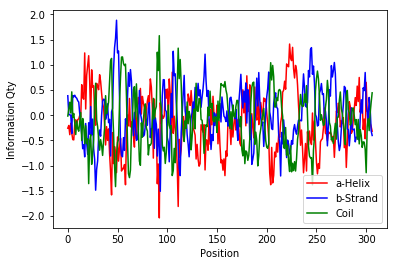

[*] Solution
Protein ID: 1AVA
aminoacid sequence: ADPPPVHDTDGHELRADANYYVLSANRAHGGGLTMAPGHGRHCPLFVSQDPNGQHDGFPVRITPYGVAPSDKIIRLSTDVRISFRAYTTCLQSTEWHIDSELAAGRRHVITGPVKDPSPSGRENAFRIEKYSGAEVHEYKLMSCGDWCQDLGVFRDLKGGAWFLGATEPYHVVVFKKAPPA
structure sequence: CCCCECECCCCCECECCCEEEEEECCHHHCCCEEEEEECCEEEEEEEEECCCCCCCCCCEEEEECCCCCCCCECECCCCEEEEECCCCCCCCCCECEECCCCECCECEEECCCCCCCCCCCHHHCEEEEECECCCCCCEEEEEECCCEEECEEECCCCCCCCEEECCCCECCEEEEEECCC
predicted sequence: CCCCCEECCCCHEHHHCHHHHHEEHCHHHCCCEEECCCCCCECCEEEECCCCCCCCCCEEEEECCCCCCCHEEEEEECCHEEEEEEHEHHEHCCEEHHHHHHHHCHEEEEECCECCCCCCCHHHHEHHEHHCCHEHEEEEEECECHCCHCHCEHECHCCCEEEECCCCCEEEEEEECCCCC
length: 181
Q3: 58.011 %
MCC_H: 0.319 
MCC_E: 0.312 
MCC_C: 0.296 



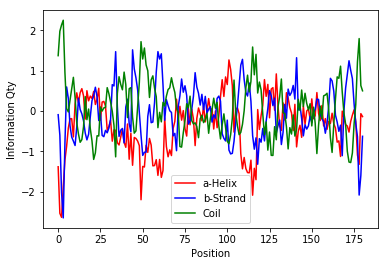

[*] Solution
Protein ID: 1AVM
aminoacid sequence: AVYTLPELPYDYSALEPYISGEIMELHHDKHHKAYVDGANTALDKLAEARDKADFGAINKLEKDLAFNLAGHVNHSVFWKNMAPKGSAPERPTDELGAAIDEFFGSFDNMKAQFTAAATGIQGSGWASLVWDPLGKRINTLQFYDHQNNLPAGSIPLLQLDMWEHAFYLQYKNVKGDYVKSWWNVVNWDDVALRFSEARVA
structure sequence: CCCCCCCCCCCCCCCCCCCCHHHHHHHHHCHHHHHHHHHHHHHHHHHHHHHHCCCCCHHHHHHHHHHHHHHHHHHHHHHHCECCCCCCCCCCCHHHHHHHHHHHCCHHHHHHHHHHHHHCCCCCEEEEEEEECCCCEEEEEEEECCCECCCCCCEEEEEEECCHHHCHHHHCCCHHHHHHHHHHHECHHHHHHHHHHHCCC
predicted sequence: EEEECCCCCCCHHHHCCHHCHEHHEEHHHHHCHEEHHCHHHHHHHHHHHHHHHHHCHHHHHHHHHHEEHCCCCCHEEHHHEHCCCCCCCCCCCHHHHHHHHHHHCCHHHHHHHHHHHEECECCCCEEEEEECCHCCEEEEEEEHECCCCCCCCCCHEEHHHHHHHHHHHHHECCCCCEEEEEEEEECHCHHHEHHHHHHHH
length: 201
Q3: 66.667 %
MCC_H: 0.415 
MCC_E: 0.348 
MCC_C: 0.497 



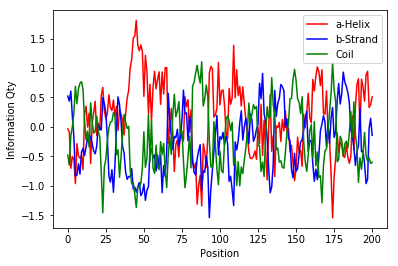

[*] Solution
Protein ID: 1HGE
aminoacid sequence: QDLPGNDNSTATLCLGHHAVPNGTLVKTITDDQIEVTNATELVQSSSTGKICNNPHRILDGIDCTLIDALLGDPHCDVFQNETWDLFVERSKAFSNCYPYDVPDYASLRSLVASSGTLEFITEGFTWTGVTQNGRSNACKRGPGSGFFSRLNWLTKSGSTYPVLNVTMPNNDNFDKLYIWGIHHPSTNQEQTSLYVQASGRVTVSTRRSQQTIIPNIGSRPWVRGLSSRISIYWTIVKPGDVLVINSNGNLIAPRGYFKMRTGKSSIMRSDAPIDTCISECITPNGSIPNDKPFQNVNKITYGACPKYVKQNTLKLATGMRNVPEKQT
structure sequence: CCCCCCCCCCEEEEEEEECCCCCEEECCCCCCCEEECCEEECEECCCCCCEEEECCCEEECCCCCHHHHHHCCHHHHHHCCCECCEEEECCCCCCCCCCEECCCHHHHHHHHHHHCECCEEECCCCCCCEEEEECEEEEEECCEEECCCCEEEEEEECCECCCEEEEEECCCCCCEEEEEEEEECCCHHHHHHHHCCCCCEEEEECCCCEEEECCCCCCCCCECCECCEEEEEEEEECCCCEEEEEEEECEEEECEEEECCCCCCEEEECCCCEEEEECCEEECCEEECCCCCEECCCCCCEEECCEECCCCCCEEECCCECCCCCCC
predicted sequence: CCCCCCCCCHEEEHECCCCCCCCEEEEEECHCEEEHHHHEEEEEECCCCEEECCCCEEECCHCEEEEHEHCCCCCCHEECHCCHHEHHHHHHEHECECCCCCCCHHHHEHHHHCCCCEEEEECCCEEEEEEECCCECEEECCCCCEEEEEHEEECCCCCCCCEEEEEECCCCCHCHEEEEEECCCCCCHHHHHEEEHCECEEEEEHCCCCEEEECCCCCCCEEEECCCEEEEEEEEECCCCEEEEECCCCEE

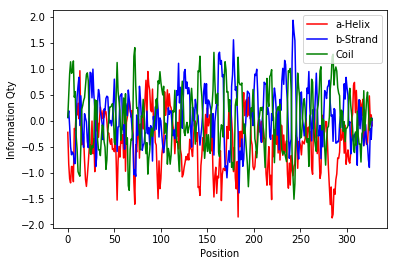

[*] Solution
Protein ID: 1HMO
aminoacid sequence: GFPIPDPYCWDISFRTFYTIIDDEHKTLFNGILLLSQADNADHLNELRRCTGKHFLNEQQLMQSSQYAGYAEHKKAHDDFIHKLDTWDGDVTYAKNWLVNHIKTIDFKYRGKI
structure sequence: CCCCCCCCCCCHHHCCCCHHHHHHHHHHHHHHHHHHHCCCHHHHHHHHHHHHHHHHHHHHHHHHCCCCCHHHHHHHHHHHHHHHHCCCCCHHHHHHHHHHHHHHCHHHHCCCC
predicted sequence: CCCCCCCCEEEEEECEEEEEHHHCCHHHHHHHEEHHHHHCHHHHHHHHHHCCCHHHHHHHHHHHHHHHHHHHHHHHCHHHEEEECCCCCCHEEHHHHHEHEHEEHCEHHCCEE
length: 113
Q3: 62.832 %
MCC_H: 0.307 
MCC_E: 0.0 
MCC_C: 0.417 



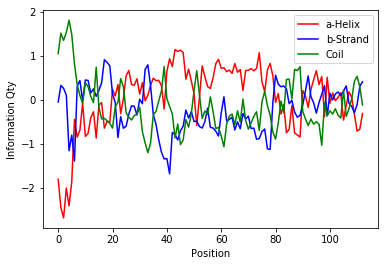

In [17]:
q3_list_puretest = []

for protein in PURE_TEST_SET:
    for chain_id in protein.chains.keys():
        a_seq = protein.chains[chain_id]['a_seq']
        s_seq = protein.chains[chain_id]['s_seq']
        gor = GOR3Evaluator(a_seq=a_seq, s_seq=s_seq, surveydic=surveydic, protid=protein.protid)
        print(gor)
        q3_list_puretest.append(gor.q3())
        gor.show_plot()

### Observations and discussions on the predictions
The previous test is done on a small set of proteins of varying length.<br>

We didn't use colors because these display differently on different jupyter installations, causing compatibility issues. A colored version is available at `img/coloured_p3.png`.


At first glance, we observe that the length of the protein sequence doesn't seem to have any impact on the outcome or the quality of the predictions.<br>
The accuracy of the predicted structures are fluctuating around the computed mean Q3, which is $\approx 61\%$.<br>

Looking at the prediction of 1HMO, we see that the MCC of the conformation E is 0. This is explained by the fact that no conformation E appears in the real structure and MCC of E is solely formed of True negatives and False positives. Therefore, True positives and false negatives are both equal to 0, $TP \cdot TN - FP \cdot FN=0$ making the value of $MCC_E=0$.

We notice that the proteins 1AVM and 1MHO yield results better the mean Q3, with $66.667 \%$ and $66.832\%$. Particularly, we remark that the MCCs for 1AVM are relatively high, compared to the average MCCs observed in previous sections, with 0.415, 0.348 and 0.497 against 0.34, 0.33 and 0.36. Furthermore, observing the plot of 1AVM, we see that in general, the quantity of information of conformations that have **not** been selected is negative, meaning the correct information particularly stands out and the algorithm is assertive with its prediction.<br>
This behavior is suspiciously better than the ones observed for other predictions.<br>
This behavior leads us to suspect that the training set contains extremely similar homologs to 1AVM, and 1MHO to a lower degree.<br>
This hypothesis can be tested using the previously implemented *NeedlemanWunsch* or *SmithWaterman* algorithms.
However, considering the size of the training set, such an experiment is computationally difficult. Therefore, we decided to use a custom made <u>heuristic</u> algorithm to find relevant proteins in the training set.

The algorithms evaluates the similarities in the proteins' name to detect potentially relevant related proteins.
The algorithm operates as follows:
```
for each protein p in dssp_test:
   similars_count = 0
   for each protein p1 in training set:
       if  string_similarity(p.name, p1.name) >= minimum_similarity:
          similars_count += 1
  print(similars_count)
```

We use python's `difflib.SequenceMatcher`, based on *"Gestalt pattern matching" Ratcliff and Obershelp 1980*, to compute string similarities.

The function is defined as follows along with a helper function that parses our dataset file:

In [18]:
def parse_dataset(filename):
    out = []
    with open(filename, 'r') as f:
        line = f.readline()
        while line:
            line = line.strip()
            if line.startswith('>'):
                pid, pname, org = line.split('|')
                a_seq = f.readline().strip()
                s_seq = f.readline().strip()
                out.append( (pid, pname, org, a_seq, s_seq))
            line = f.readline()
    return out

def find_similar_by_name(dssp_test_path, cathinfo_test, dataset_filename, similarity=0.7):
    to_test_data = parse_dssp(dssp_path=dssp_test_path, cath_info_fname=cathinfo_test)
    train_data = parse_dataset(dataset_filename)
    results = OrderedDict()

    print('{*} Testing against %s with minimum name similarity: %s' % (dataset_filename, similarity))
    for protein in to_test_data:
        count = 0
        for pid, pname, porg, a_seq, s_seq in train_data:
            s = SequenceMatcher(isjunk=lambda x: x in '0123456789', a=protein.name, b=pname)
            #s = SequenceMatcher(isjunk=None, a=protein.name, b=pname)
            if protein.name in pname or s.ratio() >= similarity:
                #print(pname)
                count += 1
        results[protein.protid] = count
        print('%s-%s : %d' % (protein.protid, protein.name, count))
    return results

We attempt to search in the training set for proteins with **minimum 80% similarity** compared to the proteins we are testing.<br>
Based on the previously emitted hypothesis, we expect to have numerous similarities for 1AVM, a few similarities for 1HMO and minimal or None for other proteins, namely 1ARL,1AVA, and 1HGE.

{*} Testing against rsrc/dataset/train.txt with minimum name similarity: 0.8
1ARL-APO-CARBOXYPEPTIDASE A=ALPHA= (COX) : 0
1AVA-BARLEY ALPHA-AMYLASE 2(CV MENUET) : 0
1AVM-SUPEROXIDE DISMUTASE : 14
1HGE-HEMAGGLUTININ, (G135R), HA1 CHAIN : 0
1HMO-HEMERYTHRIN : 2


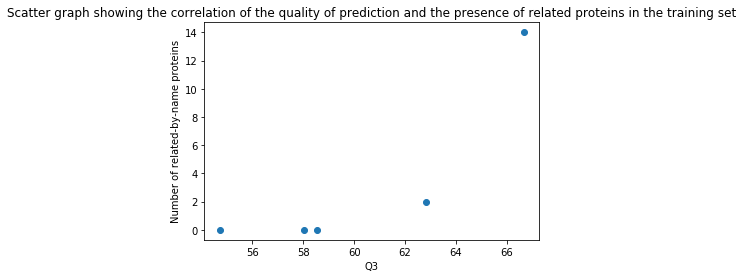

In [19]:
name_similarity_res = find_similar_by_name(
    dssp_test_path=DSSP_TEST_PATH,
    cathinfo_test=CATHINFO_TEST_FILE,
    dataset_filename=TRAIN_FILE,
    similarity=0.8
    )

# plot scatter
plt.scatter(q3_list_puretest, list(name_similarity_res.values()))
plt.title("Scatter graph showing the correlation of the quality of prediction and the presence of related proteins in the training set")
plt.xlabel("Q3")
plt.ylabel('Number of related-by-name proteins')
plt.show()

We observe that there are $14$ proteins with similar names ($80\%$) to 1AVM and $2$ proteins with similar names to 1HMO whereas 0 proteins with similar names to the other proteins,  These results are compatible with our expectations thus validating our hypothesis. Besides, the scatter figure is visually consistent with our deduction.

# Conclusion

In conclusion, we examine in this report the prediction of proteins secondary structure using the GOR3 algorithm. Key principles are explained and illustrated throughout the report.<br>

The algorithm is implemented and evaluated in an attempt to make sense of different concepts. The results are analyzed, compared to the theoretical expected values and discussed accordingly in an attempt to produce hypotheses about the outcome.<br>

We can safely say that predicting the structure of a protein sequence, as is with all machine learning algorithms, depends considerably on the dataset used for training. Although GOR3 predictions are satisfactory enough, better results can be achieved by GOR5, a later version of the algorithm.

# References
- A mathematical theory of communications, Shannon - http://www.math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf
- M.Zvelebil, J.O.Baum, (2008). Understanding bioinformatics
- GOR Method for Predicting Protein Secondary Structure from Amino Acid Sequence, GARNIER, GIBRAT, ROBSON
- https://www.uniprot.org/
- https://publications.nigms.nih.gov/psi/timeline_text.html
- GOR5 Server, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2553678/
